In [12]:
import matplotlib.pyplot as plt
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
from glob import glob

from tensorflow.keras.models import load_model
from annsa.template_sampling import rebin_spectrum
from annsa.annsa import read_spectrum
from annsa.load_pretrained_network import load_features
import pandas as pd
from annsa.template_sampling import rebin_spectrum
from annsa.generate_uranium_templates import choose_uranium_template, generate_uenriched_spectrum

## Load Models

In [2]:
all_models = {}

model_classes = ['dnn', 'cnn', 'daednn', 'caednn',]


for mode in ['easy', 'full']:
    for model_class in model_classes:
        print(model_class + ' ' + mode + '...')
        temp_models = []
        for i in range(5):
            i = str(i)
            
            
            
            temp_model = load_model(
                os.path.join(
                'final-models-keras',
                model_class+'-keras-'+mode+'_fold'+i+'.hdf5',),
                compile=False,
            )
            temp_models.append(temp_model)
        all_models[model_class+'-'+mode] = temp_models

scalers = {}
model_classes = ['dnn', 'cnn',]
for mode in ['easy', 'full']:
    for model_class in model_classes:
        architecture_id = os.path.join('..',
                                       'source-interdiction',
                                       'final_training_notebooks',
                                       'final-models',
                                       'learningcurve-'+model_class+'-'+mode+'-final-features',)
        model_features = load_features(architecture_id)
        scalers[model_class+'-'+mode] = model_features.scaler.transform
        if model_class == 'dnn':
            scalers['daednn'+'-'+mode] = model_features.scaler.transform
        if model_class == 'cnn':
            scalers['caednn'+'-'+mode] = model_features.scaler.transform


dnn easy...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
cnn easy...
daednn easy...
caednn easy...
dnn full...
cnn full...
daednn full...
caednn full...


Using TensorFlow backend.


In [3]:
def models_bagged(all_models, model_id, spectra):
    scaler = scalers[model_id]
    members = all_models[model_id]
    
    # scale inputs
    spectra_scaled = scaler(spectra)
    # make predictions
    yhats = [model.predict(spectra_scaled) for model in members]
    yhats = np.array(yhats)
    # average across ensemble members
    member_average = np.mean(yhats, axis=1)
    # average across classes
    average = np.mean(member_average, axis=0)
    return average, yhats.flatten()

# RF shells

In [4]:
background_dataset = pd.read_csv('./dataset_generation/background_template_dataset.csv')
uranium_dataset = pd.read_csv('dataset_generation/uranium_templates_final.csv')

In [5]:
markers = ['*','*','s','s','x','x','^','^']
colors = ['purple', 'green', 'purple', 'green',
          'purple', 'green', 'purple', 'green',]

In [27]:
model_id_markers = {
    'cnn' : '*',
    'dnn' : 's',
    'caednn' : '^',
    'daednn' : 'x'
    }

mode_colors = {
    'easy' : 'green',
    'full' : 'purple',
}

markersizes = {
    'cnn' : 13,
    'dnn' : 10,
    'caednn' : '^',
    'daednn' : 'x'
}

In [28]:
import matplotlib.lines as mlines

blue_star = mlines.Line2D([], [], marker='*', linestyle='None', color='k',
                          markersize=10, label='CNN1D')
red_square = mlines.Line2D([], [], color='k', marker='s', linestyle='None',
                          markersize=10, label='DNN')
purple_triangle = mlines.Line2D([], [], color='k', marker='x', linestyle='None',
                          markersize=10, label='DAE')
green_cross = mlines.Line2D([], [], color='k', marker='^', linestyle='None',
                          markersize=10, label='CAE')
easy_setting = mlines.Line2D([], [], color='green', linestyle='-', linewidth=5,
                          markersize=10, label='Simple')
full_setting = mlines.Line2D([], [], color='purple', linestyle='-', linewidth=5,
                          markersize=10, label='Complete')

# Results - Shielding

In [59]:
def plot_shielding_results(shieldingdensity,
                           integration_time=600,
                           background_cps=200,
                           calibration=[0, 1.0, 0],
                           source_background_ratio = 3,
                           enrichments=[0.03, 0.25, 0.5, 0.75, 0.93],
                           save_as=None):
    plt.figure(figsize=[9,8])
    plt.rcParams.update({'font.size': 20})
    plt.plot([0,1],[0,1], linestyle = '--') 

    for enrichment in enrichments:

        uranium_template = choose_uranium_template(
            uranium_dataset,
            sourcedist=sorted(set(uranium_dataset['sourcedist']))[1],
            sourceheight=sorted(set(uranium_dataset['sourceheight']))[0],
            shieldingdensity = shieldingdensity,
            fwhm=7.0,
        )
        source_spectra = []

        total_sampels=10

        for _ in range(total_sampels):
            source_spectrum = generate_uenriched_spectrum(
                uranium_template,
                background_dataset,
                enrichment_level=enrichment,
                integration_time=integration_time,
                background_cps=background_cps,
                calibration=calibration,
                source_background_ratio=source_background_ratio,
            )
            source_spectra.append(source_spectrum)
        for ml_model in ['cnn', 'dnn', 'caednn', 'daednn']:
            for mode in ['easy', 'full']:
                model_id = ml_model + '-' + mode
                _, output = models_bagged(all_models,
                              model_id=model_id,
                              spectra=source_spectra)
                plt.errorbar(enrichment,
                             np.average(output),
                             yerr=np.var(output),
                             marker=model_id_markers[ml_model],
                             color=mode_colors[mode],
                             markersize=13,)

    plt.xlim([-0.1, 1.1])
    plt.ylim([0, 1.1])
    plt.xlabel('Simulated Enrichment (%)')
    plt.ylabel('Predicted Enrichment (%)')

    plt.legend(handles=[blue_star, red_square, purple_triangle, green_cross, easy_setting, full_setting], fontsize=18)
    
    if save_as:
        plt.savefig(save_as)

    # plt.loglog()
    # plt.xlim([0.0001,1])
    # plt.ylim([0.0001,1])

In [60]:
for shielding_material in ['lead', 'alum', 'iron']:
    all_densities = sorted(list(set(uranium_dataset[uranium_dataset['shielding']==shielding_material]['shieldingdensity'])))
    print(shielding_material, all_densities)

lead [0.22, 0.51, 1.61]
alum [1.82, 4.18, 13.16]
iron [1.53, 3.5, 11.02]


### Plot the difference

In [61]:
shieldingdensity=0.0,
integration_time=600,
background_cps=200,
calibration=[0, 1.0, 0],
source_background_ratio = 3,
enrichments=[0.03, 0.25, 0.5, 0.75, 0.93],

Text(0, 0.5, 'Counts per Channel')

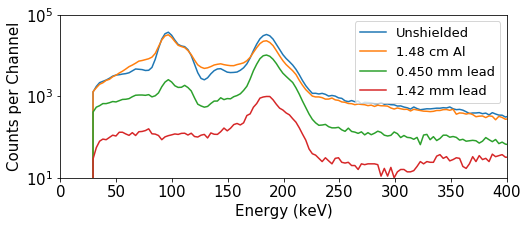

In [62]:

shielding_label = {0.0 : 'Unshielded',
                   1.82 : '1.48 cm Al',
                   0.51 : '0.450 mm lead',
                   1.61 : '1.42 mm lead',
                  }

plt.figure(figsize=(8,3))
plt.rcParams.update({'font.size': 15})


for shieldingdensity in [0.0, 1.82, 0.51, 1.61]:
    
    uranium_template = choose_uranium_template(
        uranium_dataset,
        sourcedist=sorted(set(uranium_dataset['sourcedist']))[1],
        sourceheight=sorted(set(uranium_dataset['sourceheight']))[0],
        shieldingdensity=shieldingdensity,
        fwhm=7.0,
        )

    source_spectrum = generate_uenriched_spectrum(
        uranium_template,
        background_dataset,
        enrichment_level=0.93,
        integration_time=600,
        background_cps=200,
        calibration=[0, 1.0, 0],
        source_background_ratio=3,
    )
    plt.plot(np.linspace(0,3e3,1024), source_spectrum, label=shielding_label[shieldingdensity])
plt.legend(fontsize=13)
plt.semilogy()
# plt.xlim([0,400])
# plt.ylim([1e2,5e4])
plt.xlim([0,400])
plt.ylim([1e1,1e5])
plt.xlabel('Energy (keV)')
plt.ylabel('Counts per Channel')

### Unshielded

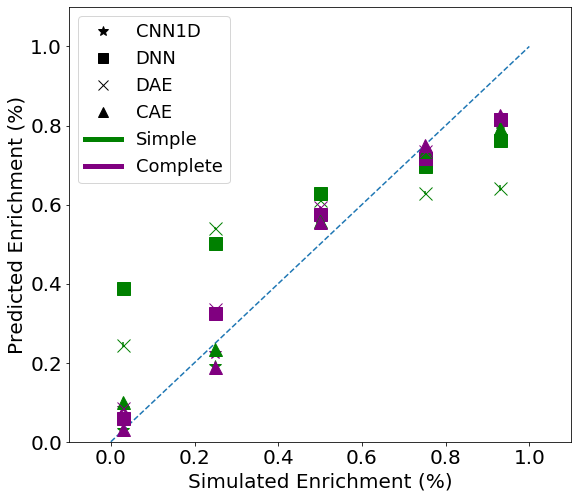

In [63]:
plot_shielding_results(shieldingdensity=0.0,
                       integration_time=600,
                       background_cps=200,
                       calibration=[0, 1.0, 0],
                       source_background_ratio = 3,
                       enrichments=[0.03, 0.25, 0.5, 0.75, 0.93],
                       save_as='images/simuranium-noshield.png')

### Light aluminum

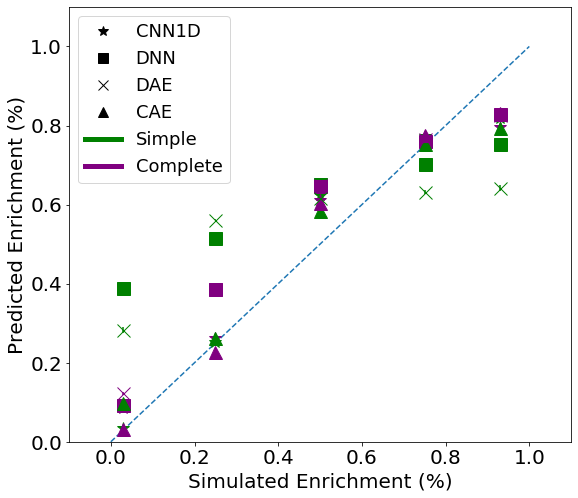

In [64]:
plot_shielding_results(shieldingdensity=1.82,
                       integration_time=600,
                       background_cps=200,
                       calibration=[0, 1.0, 0],
                       source_background_ratio = 3,
                       enrichments=[0.03, 0.25, 0.5, 0.75, 0.93],
                       save_as='images/simuranium-lightal.png')

### Medium Lead

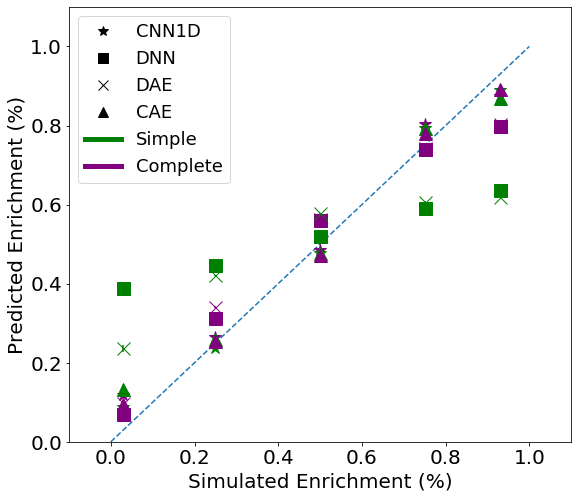

In [65]:
plot_shielding_results(shieldingdensity=0.51,
                       integration_time=600,
                       background_cps=200,
                       calibration=[0, 1.0, 0],
                       source_background_ratio = 3,
                       enrichments=[0.03, 0.25, 0.5, 0.75, 0.93],
                       save_as='images/simuranium-mediumlead.png')


### Heavy Lead

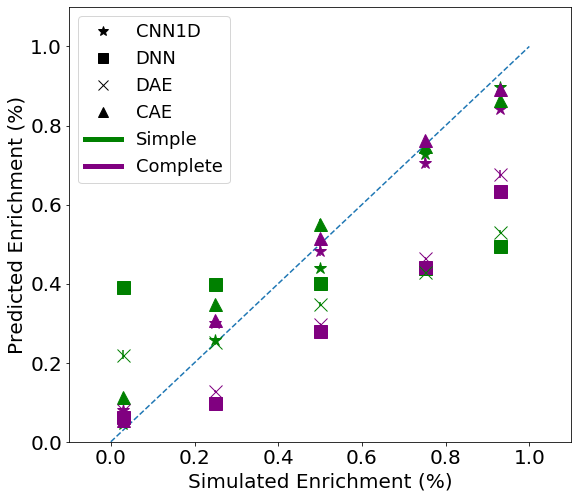

In [66]:
plot_shielding_results(shieldingdensity=1.61,
                       integration_time=600,
                       background_cps=200,
                       calibration=[0, 1.0, 0],
                       source_background_ratio = 3,
                       enrichments=[0.03, 0.25, 0.5, 0.75, 0.93],
                       save_as='images/simuranium-heavylead.png')

# Results - Calibration

Text(0, 0.5, 'Counts per Channel')

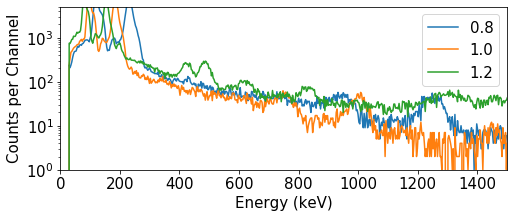

In [50]:
uranium_template = choose_uranium_template(
    uranium_dataset,
    sourcedist=sorted(set(uranium_dataset['sourcedist']))[1],
    sourceheight=sorted(set(uranium_dataset['sourceheight']))[0],
    shieldingdensity = 0.0,
    fwhm=7.0,
)

plt.figure(figsize=(8,3))
plt.rcParams.update({'font.size': 15})


for calibration in [0.8, 1.0, 1.2]:
    source_spectrum = generate_uenriched_spectrum(
        uranium_template,
        background_dataset,
        enrichment_level=0.2,
        integration_time=600,
        background_cps=200,
        calibration=[0, calibration, 0],
        source_background_ratio=4,
    )
    plt.plot(np.linspace(0,3e3,1024), source_spectrum, label=calibration)
plt.legend()
plt.semilogy()
# plt.xlim([0,400])
# plt.ylim([1e2,5e4])
plt.xlim([0,1500])
plt.ylim([1e0,5e3])
plt.xlabel('Energy (keV)')
plt.ylabel('Counts per Channel')

### 0.8

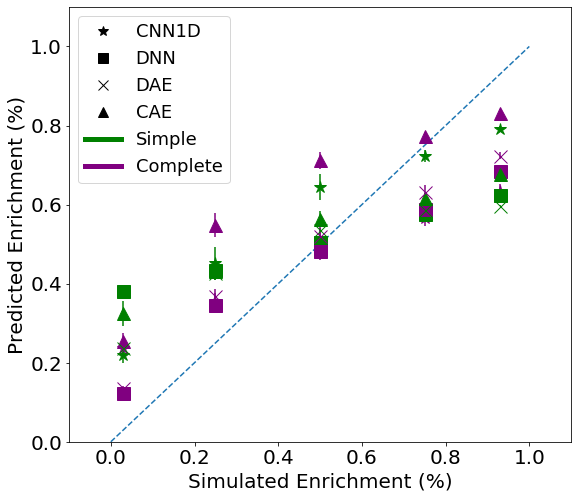

In [76]:
plot_shielding_results(shieldingdensity=0.0,
                       integration_time=600,
                       background_cps=200,
                       calibration=[0, 0.8, 0],
                       source_background_ratio = 3,
                       enrichments=[0.03, 0.25, 0.5, 0.75, 0.93],
                       save_as='images/simuranium-cal08.png')

### 0.9

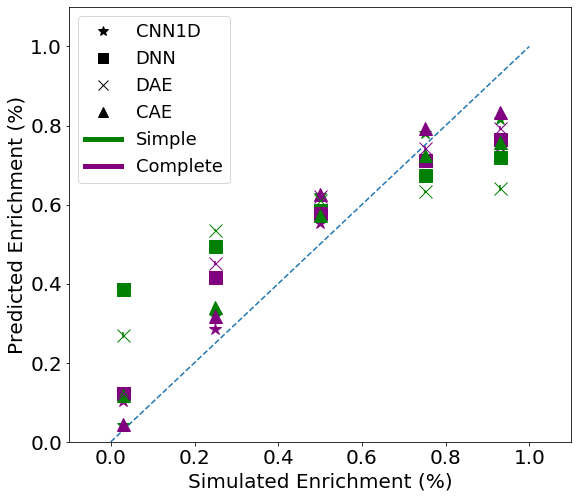

In [73]:
plot_shielding_results(shieldingdensity=0.0,
                       integration_time=600,
                       background_cps=200,
                       calibration=[0, 0.9, 0],
                       source_background_ratio = 3,
                       enrichments=[0.03, 0.25, 0.5, 0.75, 0.93],
                       save_as='images/simuranium-cal09.png')

### 1.1

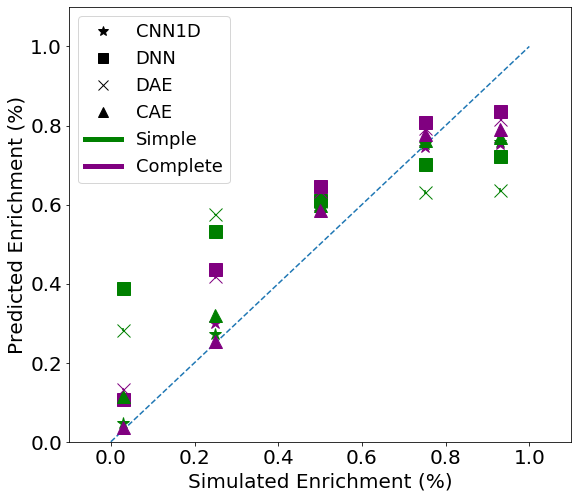

In [74]:
plot_shielding_results(shieldingdensity=0.0,
                       integration_time=600,
                       background_cps=200,
                       calibration=[0, 1.1, 0],
                       source_background_ratio = 3,
                       enrichments=[0.03, 0.25, 0.5, 0.75, 0.93],
                       save_as='images/simuranium-cal11.png',)

### 1.2

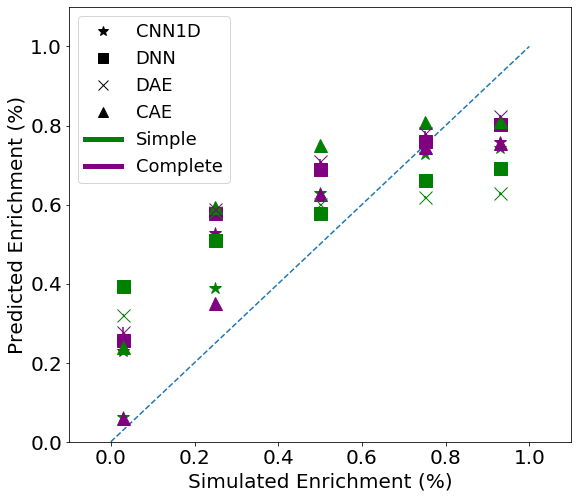

In [75]:
plot_shielding_results(shieldingdensity=0.0,
                       integration_time=600,
                       background_cps=200,
                       calibration=[0, 1.2, 0],
                       source_background_ratio = 3,
                       enrichments=[0.03, 0.25, 0.5, 0.75, 0.93],
                       save_as='images/simuranium-cal12.png',)

# Results - Signal-to-background

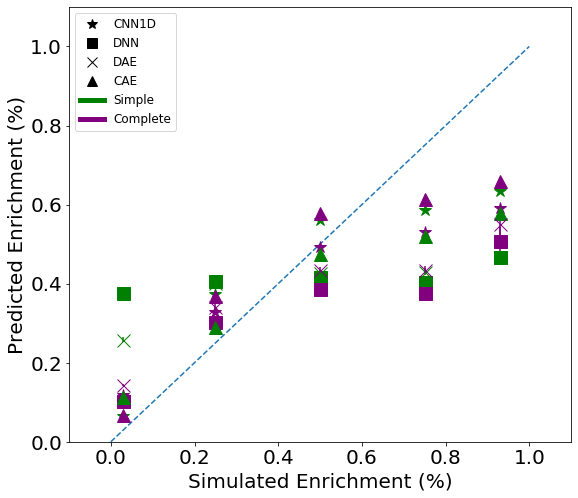

In [55]:
plot_shielding_results(shieldingdensity=0.0,
                       integration_time=600,
                       background_cps=200,
                       calibration=[0, 1.0, 0],
                       source_background_ratio = 0.5,
                       enrichments=[0.03, 0.25, 0.5, 0.75, 0.93],
                       save_as=None)

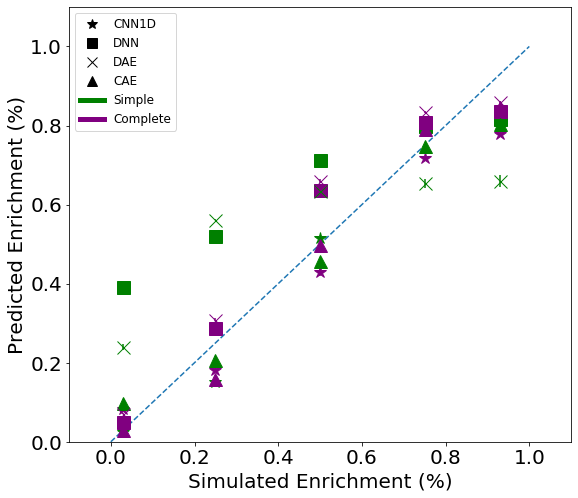

In [56]:
plot_shielding_results(shieldingdensity=0.0,
                       integration_time=600,
                       background_cps=200,
                       calibration=[0, 1.0, 0],
                       source_background_ratio = 10,
                       enrichments=[0.03, 0.25, 0.5, 0.75, 0.93],
                       save_as=None)